In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [400]:
# Directory containing CSV files
directory = 'data/'

# List to store DataFrames
dfs = []

# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame and append it to the list
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)


In [401]:
# Group the DataFrame by the 'beta' column
grouped_df = combined_df.groupby('beta')

# Create an empty dictionary to store the arrays
beta_arrays = {}

# Iterate over the groups
for beta, group in grouped_df:
    # Store the group as an array in the dictionary
    beta_arrays[beta] = group.to_numpy()


In [402]:
def plotter(depVar, col, sweepRange, plot=False):
    """Function plot dependant variable against number of sweeps
    dependantVar: give string that dependant variable will be called
    col: column index of dependant variable starting from 0
    sweepRange: range over which sweeps are plotted, always plots from zero -> may want to change
    """
    
    if plot:
        plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches
    
    # task 2
    eqns = []
    betas = []
    eqns_err = []
    
    for beta, array in beta_arrays.items(): 
        
        # find number of seeds iterated over
        max_seed = 0
        for i in range(len(array)):
            if array[i][5] > max_seed:
                max_seed = int(array[i][5]) 

        # I don't know why I have to put this in
        max_seed += 2

        # magnetisation array for task 1
        # columns are: sweeps, magnetisation, error
        independentVar = np.zeros(max_seed)
        dependantVar = np.zeros(max_seed)

        # errors
        value_squares = np.zeros(max_seed)
        value_errors = []

        # iterates over every beta value
        for i in range(len(array)):
            
            j = int(array[i][0])
            # appends sweeps
            independentVar[j] = array[i][0]
            # appends dependantVar
            dependantVar[j] += array[i][col] / 50
            # appends dependantVar squared for error stuff
            value_squares[j] += array[i][col]**2 / 50

        prefactor = 1 / ( np.sqrt( max_seed) -1 ) 
        for k in range(len(value_squares)):
            value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )
                        
        if plot:
            plt.errorbar(independentVar, dependantVar, yerr=value_errors, fmt='o', capsize=3, label=beta)
            
            plt.legend()
            # Set tick parameters inwards
            plt.tick_params(axis='both', direction='in')
            plt.xlabel('Sweeps')
            plt.xlim(0, sweepRange)

            plt.ylabel(depVar)
        
        # task 2: finding equilibrium averages
        # slice arrays
        independentVar = independentVar[10:sweepRange+1]
        dependantVar = dependantVar[10:sweepRange+1]
        value_errors = value_errors[10:sweepRange+1]
        
        eqDepVar = np.mean(dependantVar)
        eqDepVar_err = np.std(dependantVar) / np.sqrt(len(dependantVar))
        eqns.append(eqDepVar)
        betas.append(beta)
        eqns_err.append(eqDepVar_err)
        
        
        
   
    if plot:
        plt.savefig(f"figures/task1_{depVar}.png")
        plt.show()
        
    return betas, eqns, eqns_err

    

/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_5207/1483914192.py:49: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )


Text(0, 0.5, 'Equilibrium magnetisation $M$')

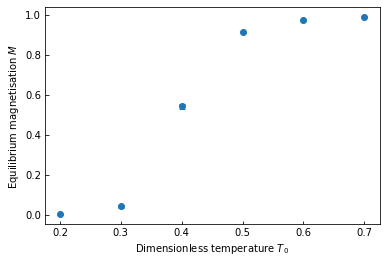

In [403]:
# task 2: calculate the equilibrium averages

# magnetisation:
betas = plotter("Magnetisation", 2, 50)[0]
eqM = plotter("Magnetisation", 2, 50)[1]
eqM_err = plotter("Magnetisation", 2, 50)[2]

plt.errorbar(betas, eqM, yerr=eqM_err, fmt='o', capsize=3)
            
# Set tick parameters inwards
plt.tick_params(axis='both', direction='in')
plt.xlabel('Dimensionless temperature $T_0$')
# plt.xlim(0, sweepRange)

plt.ylabel("Equilibrium magnetisation $M$")

/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_5207/1483914192.py:49: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )


Text(0, 0.5, 'Dimensionless energy $E$')

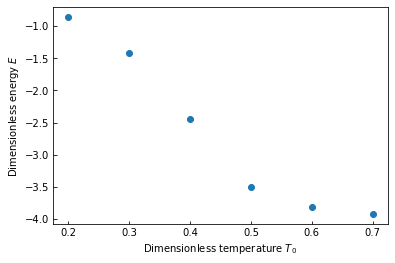

In [404]:
# energy:
betas, eqE, eqE_err = plotter("Dimensionless energy $E$", 3, 50)

plt.errorbar(betas, eqE, yerr=eqE_err, fmt='o', capsize=3)
            
# Set tick parameters inwards
plt.tick_params(axis='both', direction='in')
plt.xlabel('Dimensionless temperature $T_0$')
# plt.xlim(0, sweepRange)

plt.ylabel("Dimensionless energy $E$")
